# Modeling LC-SFC/MS data to augment separation scientists

The goal of this notebook is to give an overview of modeling ideas and approaches to model LC-SFC/MS data 

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib inline
import pandas as pd 
import rdkit
import h5py
import sys
import time
import numpy as np
import sklearn
import py3Dmol
import ipywidgets
import seaborn as sn
import matplotlib.pyplot as plt
import joblib
import random
import shap



from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import MACCSkeys
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score

from sklearn.feature_selection import VarianceThreshold
from pprint import pprint
from collections import defaultdict


In [2]:
def getDescriptorsECFP4(dataframe): #change to 4!
    morganFingerprintRingSize = 2
    info={}
    ECFP6_hashed = [Chem.GetMorganFingerprintAsBitVect(x,morganFingerprintRingSize, nBits=1024, bitInfo=info) for x in dataframe['ROMol']]

    ECFP6_hashed_lists = [list(l) for l in ECFP6_hashed]
    ECFP6_hashed_name = [f'FpBit_{i}' for i in range(1024)]

    ECFP6_hashed_df = pd.DataFrame(ECFP6_hashed_lists, index = dataframe.index, columns=ECFP6_hashed_name)

    inputDataWithDescriptorsFull = pd.concat([dataframe, ECFP6_hashed_df], axis = 1)
    # remove fingerprints with no data (doesn't remove anything with fingerprints radius of 3)                           
    inputDataWithDescriptorsFull = inputDataWithDescriptorsFull.loc[:,(inputDataWithDescriptorsFull != 0).any(axis=0)]

    print('input data has shape:', inputDataWithDescriptorsFull.shape)
    return inputDataWithDescriptorsFull

In [3]:
datafilepublic = 'Data/AZ/AZPublic.csv'

publicData = pd.read_csv(datafilepublic)
publicData = publicData.drop(["Unnamed: 0", "SampleID"], axis = 1);

publicData.head(3)

,InletMethod,SMILES,RetentionTime,MolPol,IES,IsPublic
0,grad5min_col2_alk,CN[C@@H](CCCCNC(=O)c1[nH]c2ccccc2c1c3cocc3)c4c...,135.4860,300.733032,-0.337714,Y
1,grad5min_col2_alk,O=C(CCC1CCNCC1)NS(=O)(=O)c2ccccc2,37.4148,207.016594,-0.288085,Y
2,grad5min_col1_surt,C[C@H](N1CCOCC1)c2nc(nn2C)c3cnc(N)c(n3)n4nnc5c...,85.5522,280.988672,-0.373318,Y


In [4]:
%%time
publicData.dropna(inplace=True)

PandasTools.AddMoleculeColumnToFrame(publicData,smilesCol='SMILES',includeFingerprints=True)

groupsvalidation = publicData.groupby('InletMethod')

publicWithDescriptors = getDescriptorsECFP4(publicData)
features_df = publicWithDescriptors.drop(['InletMethod','RetentionTime', 'SMILES', 'ROMol'], axis = 1)


input data has shape: (4371, 1031)
CPU times: user 19.3 s, sys: 154 ms, total: 19.5 s
Wall time: 20.2 s


In [8]:
rf = joblib.load("Model/rfModelFull.joblib")

importances_full = rf.feature_importances_
std_full = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices_total = np.argsort(importances_full)[::-1]
features_df.columns[indices_total[0:50]]

Index(['MolPol', 'IES', 'FpBit_427', 'FpBit_113', 'FpBit_481', 'FpBit_388',
       'FpBit_234', 'FpBit_146', 'FpBit_18', 'FpBit_791', 'FpBit_267',
       'FpBit_965', 'FpBit_89', 'FpBit_905', 'FpBit_407', 'FpBit_377',
       'FpBit_880', 'FpBit_618', 'FpBit_399', 'FpBit_874', 'FpBit_276',
       'FpBit_1016', 'FpBit_895', 'FpBit_491', 'FpBit_32', 'FpBit_913',
       'FpBit_729', 'FpBit_934', 'FpBit_881', 'FpBit_451', 'FpBit_879',
       'FpBit_283', 'FpBit_744', 'FpBit_501', 'FpBit_63', 'FpBit_793',
       'FpBit_830', 'FpBit_784', 'FpBit_824', 'FpBit_391', 'FpBit_318',
       'FpBit_118', 'FpBit_515', 'FpBit_228', 'FpBit_772', 'FpBit_174',
       'FpBit_270', 'FpBit_1006', 'FpBit_697', 'FpBit_120'],
      dtype='object')

In [9]:
groupsvalidation = publicData.groupby('InletMethod')
print(publicData.shape)
publicData.nunique()


(4371, 7)


InletMethod        65
SMILES           3709
RetentionTime    2371
MolPol           3709
IES              3709
IsPublic            1
ROMol            4371
dtype: int64

,InletMethod,SMILES,RetentionTime,MolPol,IES,IsPublic,ROMol,FpBit_0,FpBit_1,FpBit_2,...,FpBit_1014,FpBit_1015,FpBit_1016,FpBit_1017,FpBit_1018,FpBit_1019,FpBit_1020,FpBit_1021,FpBit_1022,FpBit_1023
0,grad5min_col2_alk,CN[C@@H](CCCCNC(=O)c1[nH]c2ccccc2c1c3cocc3)c4c...,135.4860,300.733032,-0.337714,Y,,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,grad5min_col2_alk,O=C(CCC1CCNCC1)NS(=O)(=O)c2ccccc2,37.4148,207.016594,-0.288085,Y,,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,grad5min_col1_surt,C[C@H](N1CCOCC1)c2nc(nn2C)c3cnc(N)c(n3)n4nnc5c...,85.5522,280.988672,-0.373318,Y,,0,1,0,...,0,1,0,0,0,0,0,0,0,0

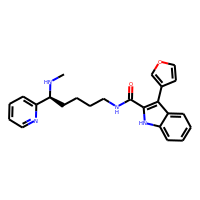
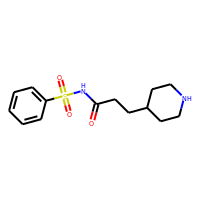
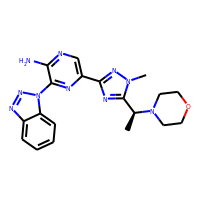

In [10]:
publicWithDescriptors.head(3)

In [11]:
def getResultsValidation(dataframe, k, rf_method_nonkallisto, rf_method, indices_total):
    features_df_method = dataframe.drop(['InletMethod','RetentionTime', 'IsPublic', 'SMILES', 'ROMol'], axis = 1)

    features_df_method_nonkallisto = features_df_method.copy()
    features_df_method_nonkallisto.drop(['MolPol', 'IES'], axis=1, inplace=True)
    
    columnsNames = features_df_method.columns[indices_total[0:k+2]]
    columnsNamesnonKallisto = columnsNames.drop(['IES', 'MolPol'])
    features_df_method_nonkallisto = features_df_method_nonkallisto[columnsNamesnonKallisto]
    features_df_method = features_df_method[columnsNames[:-2]]
    
    feature_list_method = list(features_df_method.columns)

    features_method_np = np.array(features_df_method)

    features_method_nonkallisto_np = np.array(features_df_method_nonkallisto)

    labels_method = np.array(dataframe['RetentionTime'])
    
    #train_features_method, test_features_method, train_labels_method, test_labels_method = train_test_split(features_method_np, labels_method, test_size = 0.2, random_state = 42)
    #train_features_method_nonkallisto, test_features_method_nonkallisto, train_labels_method_nonkallisto, test_labels_method_nonkallisto = train_test_split(features_method_nonkallisto_np, labels_method, test_size = 0.2, random_state = 42)

    test_features_method = features_method_np
    test_labels_method = labels_method
    test_features_method_nonkallisto = features_method_nonkallisto_np
    test_labels_method_nonkallisto = labels_method
    

    predictions_method = rf_method.predict(test_features_method)
    # Calculate the absolute errors
    errors_method = predictions_method - test_labels_method

    predictions_method_nonkallisto = rf_method_nonkallisto.predict(test_features_method_nonkallisto)
    # Calculate the absolute errors
    errors_method_nonkallisto = predictions_method_nonkallisto - test_labels_method_nonkallisto
    
    return errors_method_nonkallisto, errors_method, features_df_method

def getPerformance(errors_method_nonkallisto, errors_method, isTraining, methodName):
    kallistoMean = round(np.mean(abs(np.array(errors_method))), 3)
    nonKallistoMean = round(np.mean(abs(np.array(errors_method_nonkallisto))), 3)

    kallistoRmse = round(np.sqrt(np.mean(np.array(errors_method)**2)), 3)
    nonKallistoRmse = round(np.sqrt(np.mean(np.array(errors_method_nonkallisto)**2)), 3)
    
    if isTraining:
        dataType = 'Training'
    else:
        dataType = 'Validation'
    
    print('Mean RF Error', dataType, ':', kallistoMean, 'seconds.')
    print('Mean RF Error nonKallisto', dataType, ':', nonKallistoMean, 'seconds.')

    print('RMSE for method', dataType,':',methodName, kallistoRmse, 'seconds.')
    print('RMSE for nonKallisto method', dataType,':', methodName, nonKallistoRmse, 'seconds.')

    print('Improvement in', dataType, 'MSE is', np.round((nonKallistoMean - kallistoMean)/nonKallistoMean*100,2))
    print('Improvement in', dataType, 'RMSE is', np.round((nonKallistoRmse-kallistoRmse)/nonKallistoRmse*100,2))

In [12]:
K = 100
TotalErrors = pd.DataFrame({})
TotalErrors

""


In [13]:
%%time
# training data
methodName = 'Standard_3min_col2_alk'
k = K

rf_method_nonkallisto = joblib.load("Model/rfModelLCAlkNonKallisto.joblib")
rf_method = joblib.load("Model/rfModelLCAlk.joblib")

newDf = publicWithDescriptors.loc[groupsvalidation.groups[methodName]]
print('There are', newDf.shape[0],'data points in the validation dataset')

errors_method_nonkallisto, errors_method, features_df_method = getResultsValidation(newDf, k, rf_method_nonkallisto, rf_method, indices_total)
getPerformance(errors_method_nonkallisto, errors_method, False, methodName)

method = pd.Series(['With Kallisto'])
methodNon = pd.Series(['Without Kallisto'])

siz = errors_method.shape[0]
methodNameSe = pd.Series(methodName).repeat(siz)


errorKallisto = np.vstack([errors_method, method.repeat(siz), methodNameSe]).T
errorKallistoNon = np.vstack([errors_method_nonkallisto, methodNon.repeat(siz), methodNameSe]).T

dfErrors = pd.DataFrame(data=errorKallisto)
dfErrorsKallisto = pd.DataFrame(data=errorKallistoNon)

Errors = pd.concat([dfErrors, dfErrorsKallisto], axis=0, ignore_index=True)

Errors = Errors.rename(columns={0:"errors", 1:"feature type", 2:"method name"})
Errors = Errors.astype({'errors': 'float'})

TotalErrors = pd.concat([Errors, TotalErrors], axis=0, ignore_index=True)
TotalErrors;

There are 875 data points in the validation dataset
Mean RF Error Validation : 14.478 seconds.
Mean RF Error nonKallisto Validation : 15.492 seconds.
RMSE for method Validation : Standard_3min_col2_alk 20.904 seconds.
RMSE for nonKallisto method Validation : Standard_3min_col2_alk 21.681 seconds.
Improvement in Validation MSE is 6.55
Improvement in Validation RMSE is 3.58
CPU times: user 96.7 ms, sys: 4.01 ms, total: 101 ms
Wall time: 137 ms


,errors,feature type,method name
0,-12.110239,With Kallisto,Standard_3min_col2_alk
1,-4.126869,With Kallisto,Standard_3min_col2_alk
2,-16.785775,With Kallisto,Standard_3min_col2_alk
3,-6.900068,With Kallisto,Standard_3min_col2_alk
4,-3.964478,With Kallisto,Standard_3min_col2_alk
...,...,...,...
1745,-7.442378,Without Kallisto,Standard_3min_col2_alk
1746,7.017361,Without Kallisto,Standard_3min_col2_alk
1747,5.989359,Without Kallisto,Standard_3min_col2_alk
1748,-4.921618,Without Kallisto,Standard_3min_col2_alk


In [14]:
%%time
# training data
methodName = 'Standard_3min_col3_sur'
k = K

rf_method_nonkallisto = joblib.load("Model/rfModelLCSurNonKallisto.joblib")
rf_method = joblib.load("Model/rfModelLCSur.joblib")

newDf = publicWithDescriptors.loc[groupsvalidation.groups[methodName]]
print('There are', newDf.shape[0],'data points in the validation dataset')

errors_method_nonkallisto, errors_method, features_df_method = getResultsValidation(newDf, k, rf_method_nonkallisto, rf_method, indices_total)
getPerformance(errors_method_nonkallisto, errors_method, False, methodName)

method = pd.Series(['With Kallisto'])
methodNon = pd.Series(['Without Kallisto'])

siz = errors_method.shape[0]
methodNameSe = pd.Series(methodName).repeat(siz)


errorKallisto = np.vstack([errors_method, method.repeat(siz), methodNameSe]).T
errorKallistoNon = np.vstack([errors_method_nonkallisto, methodNon.repeat(siz), methodNameSe]).T

dfErrors = pd.DataFrame(data=errorKallisto)
dfErrorsKallisto = pd.DataFrame(data=errorKallistoNon)

Errors = pd.concat([dfErrors, dfErrorsKallisto], axis=0, ignore_index=True)

Errors = Errors.rename(columns={0:"errors", 1:"feature type", 2:"method name"})
Errors = Errors.astype({'errors': 'float'})

TotalErrors = pd.concat([Errors, TotalErrors], axis=0, ignore_index=True)
TotalErrors;

There are 851 data points in the validation dataset
Mean RF Error Validation : 13.973 seconds.
Mean RF Error nonKallisto Validation : 14.094 seconds.
RMSE for method Validation : Standard_3min_col3_sur 19.558 seconds.
RMSE for nonKallisto method Validation : Standard_3min_col3_sur 20.089 seconds.
Improvement in Validation MSE is 0.86
Improvement in Validation RMSE is 2.64
CPU times: user 98.8 ms, sys: 3.94 ms, total: 103 ms
Wall time: 122 ms


,errors,feature type,method name
0,-4.062712,With Kallisto,Standard_3min_col3_sur
1,5.938354,With Kallisto,Standard_3min_col3_sur
2,6.999299,With Kallisto,Standard_3min_col3_sur
3,-22.186366,With Kallisto,Standard_3min_col3_sur
4,-0.301116,With Kallisto,Standard_3min_col3_sur
...,...,...,...
3447,-7.442378,Without Kallisto,Standard_3min_col2_alk
3448,7.017361,Without Kallisto,Standard_3min_col2_alk
3449,5.989359,Without Kallisto,Standard_3min_col2_alk
3450,-4.921618,Without Kallisto,Standard_3min_col2_alk


In [15]:
%%time
# training data
methodName = 'BEH_NH3_3'
k = K

rf_method_nonkallisto = joblib.load("Model/rfModelSFCBEHNonKallisto.joblib")
rf_method = joblib.load("Model/rfModelSFCBEH.joblib")

newDf = publicWithDescriptors.loc[groupsvalidation.groups[methodName]]
print('There are', newDf.shape[0],'data points in the validation dataset')

errors_method_nonkallisto, errors_method, features_df_method = getResultsValidation(newDf, k, rf_method_nonkallisto, rf_method, indices_total)
getPerformance(errors_method_nonkallisto, errors_method, False, methodName)

method = pd.Series(['With Kallisto'])
methodNon = pd.Series(['Without Kallisto'])

siz = errors_method.shape[0]
methodNameSe = pd.Series(methodName).repeat(siz)


errorKallisto = np.vstack([errors_method, method.repeat(siz), methodNameSe]).T
errorKallistoNon = np.vstack([errors_method_nonkallisto, methodNon.repeat(siz), methodNameSe]).T

dfErrors = pd.DataFrame(data=errorKallisto)
dfErrorsKallisto = pd.DataFrame(data=errorKallistoNon)

Errors = pd.concat([dfErrors, dfErrorsKallisto], axis=0, ignore_index=True)

Errors = Errors.rename(columns={0:"errors", 1:"feature type", 2:"method name"})
Errors = Errors.astype({'errors': 'float'})

TotalErrors = pd.concat([Errors, TotalErrors], axis=0, ignore_index=True)
TotalErrors;

There are 487 data points in the validation dataset
Mean RF Error Validation : 19.377 seconds.
Mean RF Error nonKallisto Validation : 18.41 seconds.
RMSE for method Validation : BEH_NH3_3 27.198 seconds.
RMSE for nonKallisto method Validation : BEH_NH3_3 26.458 seconds.
Improvement in Validation MSE is -5.25
Improvement in Validation RMSE is -2.8
CPU times: user 86.3 ms, sys: 1.98 ms, total: 88.3 ms
Wall time: 138 ms


,errors,feature type,method name
0,-2.905292,With Kallisto,BEH_NH3_3
1,-6.324466,With Kallisto,BEH_NH3_3
2,2.325148,With Kallisto,BEH_NH3_3
3,-7.249030,With Kallisto,BEH_NH3_3
4,7.276904,With Kallisto,BEH_NH3_3
...,...,...,...
4421,-7.442378,Without Kallisto,Standard_3min_col2_alk
4422,7.017361,Without Kallisto,Standard_3min_col2_alk
4423,5.989359,Without Kallisto,Standard_3min_col2_alk
4424,-4.921618,Without Kallisto,Standard_3min_col2_alk


In [16]:
%%time
# training data
methodName = 'BEH_NH3_H2O_B2_4'
k = 25

rf_method_nonkallisto = joblib.load("Model/rfModelSFCBEHH20NonKallisto.joblib")
rf_method = joblib.load("Model/rfModelSFCBEHH20.joblib")

newDf = publicWithDescriptors.loc[groupsvalidation.groups[methodName]]
print('There are', newDf.shape[0],'data points in the validation dataset')

errors_method_nonkallisto, errors_method, features_df_method = getResultsValidation(newDf, k, rf_method_nonkallisto, rf_method, indices_total)
getPerformance(errors_method_nonkallisto, errors_method, False, methodName)

method = pd.Series(['With Kallisto'])
methodNon = pd.Series(['Without Kallisto'])

siz = errors_method.shape[0]
methodNameSe = pd.Series(methodName).repeat(siz)


errorKallisto = np.vstack([errors_method, method.repeat(siz), methodNameSe]).T
errorKallistoNon = np.vstack([errors_method_nonkallisto, methodNon.repeat(siz), methodNameSe]).T

dfErrors = pd.DataFrame(data=errorKallisto)
dfErrorsKallisto = pd.DataFrame(data=errorKallistoNon)

Errors = pd.concat([dfErrors, dfErrorsKallisto], axis=0, ignore_index=True)

Errors = Errors.rename(columns={0:"errors", 1:"feature type", 2:"method name"})
Errors = Errors.astype({'errors': 'float'})

TotalErrors = pd.concat([Errors, TotalErrors], axis=0, ignore_index=True)
TotalErrors;

There are 227 data points in the validation dataset
Mean RF Error Validation : 21.556 seconds.
Mean RF Error nonKallisto Validation : 25.936 seconds.
RMSE for method Validation : BEH_NH3_H2O_B2_4 29.948 seconds.
RMSE for nonKallisto method Validation : BEH_NH3_H2O_B2_4 34.73 seconds.
Improvement in Validation MSE is 16.89
Improvement in Validation RMSE is 13.77
CPU times: user 75.1 ms, sys: 3.9 ms, total: 79 ms
Wall time: 133 ms


,errors,feature type,method name
0,11.392812,With Kallisto,BEH_NH3_H2O_B2_4
1,-13.186970,With Kallisto,BEH_NH3_H2O_B2_4
2,-3.095222,With Kallisto,BEH_NH3_H2O_B2_4
3,-44.566449,With Kallisto,BEH_NH3_H2O_B2_4
4,5.141986,With Kallisto,BEH_NH3_H2O_B2_4
...,...,...,...
4875,-7.442378,Without Kallisto,Standard_3min_col2_alk
4876,7.017361,Without Kallisto,Standard_3min_col2_alk
4877,5.989359,Without Kallisto,Standard_3min_col2_alk
4878,-4.921618,Without Kallisto,Standard_3min_col2_alk


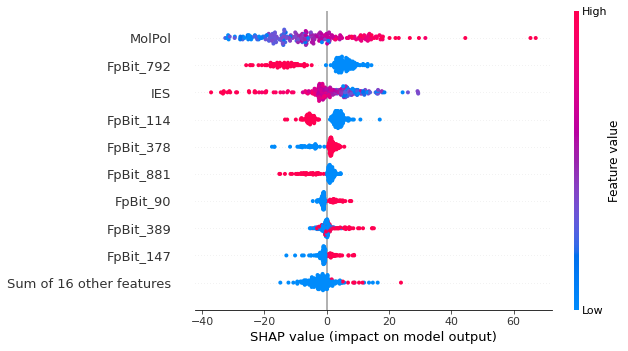

In [17]:
fig = plt.figure()
explainer = shap.Explainer(rf_method)
shap_values = explainer(features_df_method)
shap.plots.beeswarm(shap_values, show=False)
                    
plt.savefig('Output/SHAPImportances.pdf',dpi = 150,bbox_inches = 'tight')


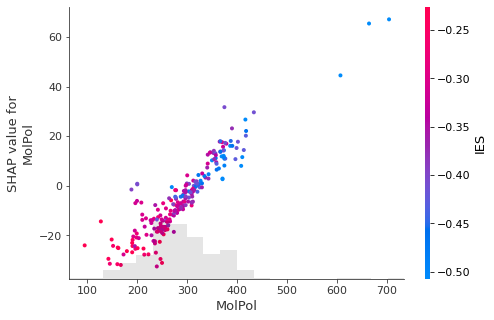

In [18]:
shap.plots.scatter(shap_values[:,0], color=shap_values)


In [19]:
%%time
# training data
methodName = 'Luna_NH3_1'
k = K

rf_method_nonkallisto = joblib.load("Model/rfModelSFCLunaNonKallisto.joblib")
rf_method = joblib.load("Model/rfModelSFCLuna.joblib")

newDf = publicWithDescriptors.loc[groupsvalidation.groups[methodName]]
print('There are', newDf.shape[0],'data points in the validation dataset')

errors_method_nonkallisto, errors_method, features_df_method = getResultsValidation(newDf, k, rf_method_nonkallisto, rf_method, indices_total)
getPerformance(errors_method_nonkallisto, errors_method, False, methodName)

method = pd.Series(['With Kallisto'])
methodNon = pd.Series(['Without Kallisto'])

siz = errors_method.shape[0]
methodNameSe = pd.Series(methodName).repeat(siz)


errorKallisto = np.vstack([errors_method, method.repeat(siz), methodNameSe]).T
errorKallistoNon = np.vstack([errors_method_nonkallisto, methodNon.repeat(siz), methodNameSe]).T

dfErrors = pd.DataFrame(data=errorKallisto)
dfErrorsKallisto = pd.DataFrame(data=errorKallistoNon)

Errors = pd.concat([dfErrors, dfErrorsKallisto], axis=0, ignore_index=True)

Errors = Errors.rename(columns={0:"errors", 1:"feature type", 2:"method name"})
Errors = Errors.astype({'errors': 'float'})

TotalErrors = pd.concat([Errors, TotalErrors], axis=0, ignore_index=True)


There are 495 data points in the validation dataset
Mean RF Error Validation : 17.813 seconds.
Mean RF Error nonKallisto Validation : 19.923 seconds.
RMSE for method Validation : Luna_NH3_1 24.891 seconds.
RMSE for nonKallisto method Validation : Luna_NH3_1 27.384 seconds.
Improvement in Validation MSE is 10.59
Improvement in Validation RMSE is 9.1
CPU times: user 86.6 ms, sys: 2.96 ms, total: 89.5 ms
Wall time: 166 ms


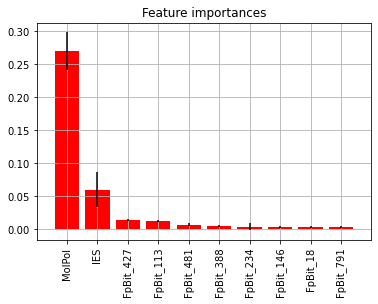

In [20]:
importances_method = rf_method.feature_importances_
std_method = np.std([tree.feature_importances_ for tree in rf_method.estimators_], axis=0)
indices_method = np.argsort(importances_method)[::-1]
features_df_method.columns[indices_method[0:50]]

k = 10
plt.figure()
plt.title("Feature importances")
plt.bar(range(k), importances_full[indices_full[0:k]],
        color="r", yerr=std_full[indices_full[0:k]], align="center")
plt.xticks(range(k), features_df.columns[indices_full[0:k]], rotation='vertical')
plt.xlim([-1, k])
plt.savefig('Output/AZImportances.pdf')
plt.grid(True)

plt.show()

In [21]:
%%time
# training data
methodName = 'EP_NH3_2'
k = K

rf_method_nonkallisto = joblib.load("Model/rfModelSFCEPNonKallisto.joblib")
rf_method = joblib.load("Model/rfModelSFCEP.joblib")

newDf = publicWithDescriptors.loc[groupsvalidation.groups[methodName]]
print('There are', newDf.shape[0],'data points in the validation dataset')

errors_method_nonkallisto, errors_method, features_df_method = getResultsValidation(newDf, k, rf_method_nonkallisto, rf_method, indices_total)
getPerformance(errors_method_nonkallisto, errors_method, False, methodName)

method = pd.Series(['With Kallisto'])
methodNon = pd.Series(['Without Kallisto'])

siz = errors_method.shape[0]
methodNameSe = pd.Series(methodName).repeat(siz)


errorKallisto = np.vstack([errors_method, method.repeat(siz), methodNameSe]).T
errorKallistoNon = np.vstack([errors_method_nonkallisto, methodNon.repeat(siz), methodNameSe]).T

dfErrors = pd.DataFrame(data=errorKallisto)
dfErrorsKallisto = pd.DataFrame(data=errorKallistoNon)

Errors = pd.concat([dfErrors, dfErrorsKallisto], axis=0, ignore_index=True)

Errors = Errors.rename(columns={0:"errors", 1:"feature type", 2:"method name"})
Errors = Errors.astype({'errors': 'float'})

TotalErrors = pd.concat([Errors, TotalErrors], axis=0, ignore_index=True)
TotalErrors;

There are 502 data points in the validation dataset
Mean RF Error Validation : 14.282 seconds.
Mean RF Error nonKallisto Validation : 15.173 seconds.
RMSE for method Validation : EP_NH3_2 20.382 seconds.
RMSE for nonKallisto method Validation : EP_NH3_2 21.358 seconds.
Improvement in Validation MSE is 5.87
Improvement in Validation RMSE is 4.57
CPU times: user 85.9 ms, sys: 3.86 ms, total: 89.8 ms
Wall time: 169 ms


,errors,feature type,method name
0,-12.008058,With Kallisto,EP_NH3_2
1,-0.802733,With Kallisto,EP_NH3_2
2,19.522133,With Kallisto,EP_NH3_2
3,-4.224231,With Kallisto,EP_NH3_2
4,8.565355,With Kallisto,EP_NH3_2
...,...,...,...
6869,-7.442378,Without Kallisto,Standard_3min_col2_alk
6870,7.017361,Without Kallisto,Standard_3min_col2_alk
6871,5.989359,Without Kallisto,Standard_3min_col2_alk
6872,-4.921618,Without Kallisto,Standard_3min_col2_alk


In [22]:
stringlist = ['11.7','10.9','16.9','6.9', '2.5', '10.0']
xposlist = range(len(stringlist))
yposlist = np.zeros(len(stringlist))-70


In [23]:
TotalErrors.loc[TotalErrors['method name'] == 'EP_NH3_2','method name'] = 'SFC-4'
TotalErrors.loc[TotalErrors['method name'] == 'Luna_NH3_1','method name'] = 'SFC-3'
TotalErrors.loc[TotalErrors['method name'] == 'BEH_NH3_H2O_B2_4','method name'] = 'SFC-2'
TotalErrors.loc[TotalErrors['method name'] == 'BEH_NH3_3','method name'] = 'SFC-1'
TotalErrors.loc[TotalErrors['method name'] == 'Standard_3min_col3_sur','method name'] = 'LC-2'
TotalErrors.loc[TotalErrors['method name'] == 'Standard_3min_col2_alk','method name'] = 'LC-1'



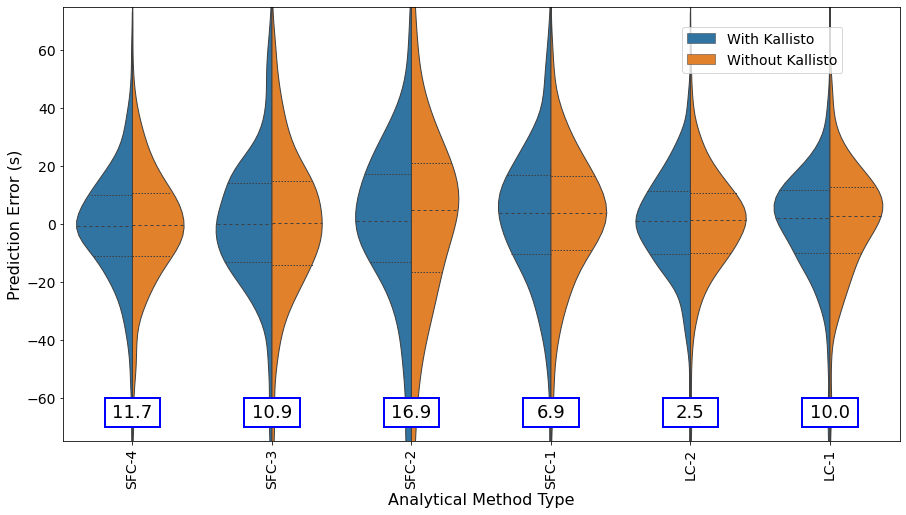

In [24]:
import seaborn as sns
from matplotlib import pyplot as plt, patches

#sns.violinplot(data=Errors, y="errors", hue="feature type",
#               split=True, inner="quart", linewidth=1,
#               palette={"Yes": "b", "No": ".85"})

#sns.violinplot(data = Errors, y = 'errors')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(15,8)
sns.violinplot(data = TotalErrors, x="method name", y ='errors', hue='feature type', split=True,  inner="quart", linewidth=1)
ax.tick_params(axis='x', rotation=90)
plt.ylim(-75, 75)


for i in range(len(stringlist)):
    #ax.text(xposlist[i], yposlist[i], stringlist[i], fontsize='xx-large', rectangle=dict( boxstyle='square', fc="w", ec=(0., 0.5, 1.)))
    rectangle = patches.Rectangle((-0.2 + xposlist[i], -70), 0.4, 10, edgecolor='blue', facecolor="white", linewidth=2)

    ax.add_patch(rectangle)
    rx, ry = rectangle.get_xy()
    cx = rx + rectangle.get_width()/2.0
    cy = ry + rectangle.get_height()/2.0
    ax.annotate(stringlist[i], (cx, cy), color='black', fontsize=18, ha='center', va='center')
    plt.xticks(fontsize= 14 )
    plt.yticks(fontsize= 14 )
    plt.ylabel("Prediction Error (s)", fontsize=16)
    plt.xlabel("Analytical Method Type", fontsize=16)

    plt.legend(bbox_to_anchor = [0.94, 0.97], prop={'size': 14})



sns.set_style("whitegrid")
plt.savefig('Output/violinplot.pdf')
